In [1]:
import os

exp_dates = [f for f in os.listdir("results")]
exp_dates.sort()

exp_dir = f"results/{exp_dates[-1]}"

config_dirs = [f for f in os.listdir(exp_dir) if f.startswith("configuration")]
config_dirs.sort()

os.makedirs(f"{exp_dir}/plots", exist_ok=True)

print(exp_dir)

results/2021-07-06T07:44:36.060012158+00:00


In [2]:
# latency cdfs data

import json
from collections import defaultdict
from datetime import datetime, timezone, timedelta

timings = defaultdict(lambda: defaultdict(list)) # mapping from config json to latency list

for config in config_dirs:
    print("processing", config)
    c = json.dumps(json.loads("".join(open(f"{exp_dir}/{config}/configuration.json").readlines())))
    
    for repeat in os.listdir(f"{exp_dir}/{config}"):
        if repeat.startswith("repeat"): 
            # read logs of docker-bench
            with open(f"{exp_dir}/{config}/{repeat}/logs/docker-bench.log", "r") as log:
                for line in log.readlines():
                    j = line.split()[1]
                    
                    try:
                        output = json.loads(j)
                    except ValueError:
                        continue
                    
                    start_secs = output["start"]["secs_since_epoch"]
                    start_nanos = output["start"]["nanos_since_epoch"]
                    start = datetime(1970, 1, 1, tzinfo=timezone.utc) + timedelta(seconds=start_secs,microseconds=start_nanos/1000)

                    end_secs = output["end"]["secs_since_epoch"]
                    end_nanos = output["end"]["nanos_since_epoch"]
                    end = datetime(1970, 1, 1, tzinfo=timezone.utc) + timedelta(seconds=end_secs,microseconds=end_nanos/1000)
                    
                    latency = end - start
                    timings[c]["starts"].append(start)
                    timings[c]["ends"].append(end)
                    timings[c]["latencies"].append((latency / timedelta(microseconds=1))/1000.)

processing configuration-01
processing configuration-02
processing configuration-03
processing configuration-04
processing configuration-05
processing configuration-06
processing configuration-07
processing configuration-08
processing configuration-09
processing configuration-10


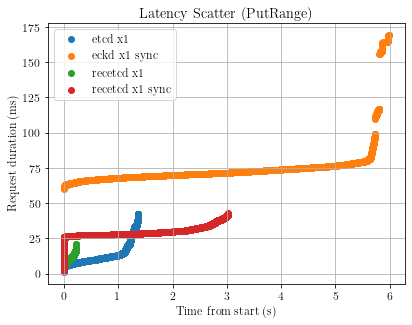

In [20]:
# latency scatter plots

import numpy as np
import matplotlib.pyplot as plt

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.size": 12,
})

f = plt.figure()
f.set_figwidth(6.4 * 1)
f.set_figheight(4.8 * 1)
    
for (k, v) in timings.items():
    config = json.loads(k)
    bench_type = config["bench_type"]
    if bench_type != "PutRange":
        continue
        
    cluster_size = config["cluster_size"]
    if cluster_size == 1:
        if config["image_name"] == "quay.io/coreos/etcd":
            image = "etcd"
        elif config["image_name"] == "jeffas/eckd":
            image = "eckd"
        elif config["image_name"] == "jeffas/recetcd":
            image = "recetcd"
        else:
            print("unmatched image name:", config["image_name"])

        sync = " sync" if "--sync" in config["extra_args"] else ""

        starts = v["starts"]
        start = starts[0]
        starts = [(s - start) / timedelta(seconds=1) for s in starts]
        latencies = v["latencies"]

        plt.scatter(starts, latencies, label=f"{image} x{cluster_size}{sync}")

plt.grid()
plt.title("Latency Scatter (PutRange)")
plt.xlabel("Time from start (s)")
plt.ylabel("Request duration (ms)")
plt.legend()

plt.savefig(f"{exp_dir}/plots/latency-scatter-putrange.pdf")

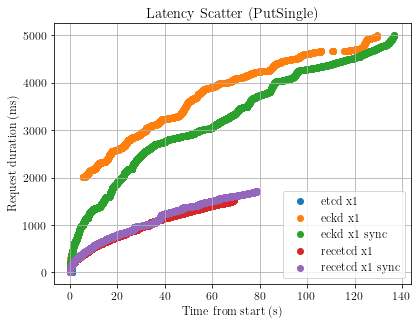

In [21]:
# latency scatter plots

import numpy as np
import matplotlib.pyplot as plt

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.size": 12,
})

f = plt.figure()
f.set_figwidth(6.4 * 1)
f.set_figheight(4.8 * 1)
    
for (k, v) in timings.items():
    config = json.loads(k)
    bench_type = config["bench_type"]
    if bench_type != "PutSingle":
        continue
        
    cluster_size = config["cluster_size"]
    if cluster_size == 1:
        if config["image_name"] == "quay.io/coreos/etcd":
            image = "etcd"
        elif config["image_name"] == "jeffas/eckd":
            image = "eckd"
        elif config["image_name"] == "jeffas/recetcd":
            image = "recetcd"
        else:
            print("unmatched image name:", config["image_name"])

        sync = " sync" if "--sync" in config["extra_args"] else ""

        starts = v["starts"]
        start = starts[0]
        starts = [(s - start) / timedelta(seconds=1) for s in starts]
        latencies = v["latencies"]

        plt.scatter(starts, latencies, label=f"{image} x{cluster_size}{sync}")

plt.grid()
plt.title("Latency Scatter (PutSingle)")
plt.xlabel("Time from start (s)")
plt.ylabel("Request duration (ms)")
plt.legend()

plt.savefig(f"{exp_dir}/plots/latency-scatter-putsingle.pdf")

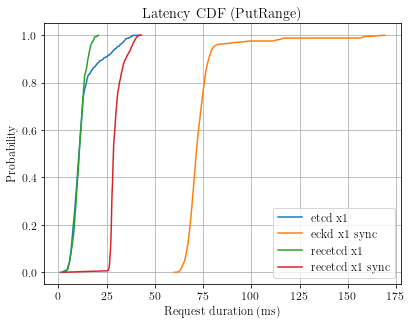

In [4]:
# latency cdfs plots

import numpy as np
import matplotlib.pyplot as plt

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.size": 12,
})

f = plt.figure()
f.set_figwidth(6.4 * 1)
f.set_figheight(4.8 * 1)
    
for (k, v) in timings.items():
    config = json.loads(k)
    bench_type = config["bench_type"]
    if bench_type != "PutRange":
        continue
        
    cluster_size = config["cluster_size"]
    if cluster_size == 1:
        if config["image_name"] == "quay.io/coreos/etcd":
            image = "etcd"
        elif config["image_name"] == "jeffas/eckd":
            image = "eckd"
        elif config["image_name"] == "jeffas/recetcd":
            image = "recetcd"
        else:
            print("unmatched image name:", config["image_name"])

        sync = " sync" if "--sync" in config["extra_args"] else ""

        latencies = v["latencies"]
        latencies.sort()
        size = len(latencies)
        ys = np.array(range(size))/ float(size)

        plt.plot(latencies, ys, label=f"{image} x{cluster_size}{sync}")

plt.grid()
plt.title("Latency CDF (PutRange)")
plt.xlabel("Request duration (ms)")
plt.ylabel("Probability")
plt.legend()

plt.savefig(f"{exp_dir}/plots/latency-cdf-putrange.pdf")

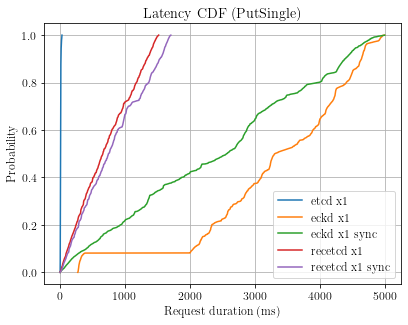

In [5]:
# latency cdfs plots

import numpy as np
import matplotlib.pyplot as plt

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.size": 12,
})

f = plt.figure()
f.set_figwidth(6.4 * 1)
f.set_figheight(4.8 * 1)
    
for (k, v) in timings.items():
    config = json.loads(k)
    bench_type = config["bench_type"]
    if bench_type != "PutSingle":
        continue
        
    cluster_size = config["cluster_size"]
    if cluster_size == 1:
        if config["image_name"] == "quay.io/coreos/etcd":
            image = "etcd"
        elif config["image_name"] == "jeffas/eckd":
            image = "eckd"
        elif config["image_name"] == "jeffas/recetcd":
            image = "recetcd"
        else:
            print("unmatched image name:", config["image_name"])

        sync = " sync" if "--sync" in config["extra_args"] else ""

        latencies = v["latencies"]
        latencies.sort()
        size = len(latencies)
        ys = np.array(range(size))/ float(size)

        plt.plot(latencies, ys, label=f"{image} x{cluster_size}{sync}")

plt.grid()
plt.title("Latency CDF (PutSingle)")
plt.xlabel("Request duration (ms)")
plt.ylabel("Probability")
plt.legend()

plt.savefig(f"{exp_dir}/plots/latency-cdf-putsingle.pdf")

In [6]:
# get cpu data

import json
from collections import defaultdict
from datetime import datetime, timezone, timedelta

cpu_usage = {} # mapping from config json to cpu usage list
mem_usage = {} # mapping from config json to mem usage list

for config in config_dirs:
    print("processing", config)
    c = json.dumps(json.loads("".join(open(f"{exp_dir}/{config}/configuration.json").readlines())))
    
    for repeat in os.listdir(f"{exp_dir}/{config}"):
        if repeat.startswith("repeat"):
            with open(f"{exp_dir}/{config}/{repeat}/logs/docker-bench.log", "r") as log:
                for line in log.readlines():
                    j = line.split()[1]
                    try:
                        output = json.loads(j)
                    except ValueError:
                        continue

                    start_secs = output["start"]["secs_since_epoch"]
                    start_nanos = output["start"]["nanos_since_epoch"]
                    start = datetime(1970, 1, 1) + timedelta(seconds=start_secs,microseconds=start_nanos/1000)
                    break
                    
            # read metrics of node*
            with open(f"{exp_dir}/{config}/{repeat}/metrics/docker-node1.stat", "r") as stats:
                times = []
                cpus = []
                mems = []
                for line in stats.readlines():
                    sp = line.split()
                    
                    dt = sp[0]
                    dt = dt.replace("+00:00","")
                    dot = dt.find(".")
        
                    dt = datetime.fromisoformat(dt[:dot+7])
             
                    times.append(dt-start)
                    j = sp[1]
                    
                    output = json.loads(j)
                    
                    # from https://github.com/docker/cli/blob/bf4a96e5640f86860e68622d2498039d86bf5714/cli/command/container/stats_helpers.go#L166
                    cpu_percent = 0
                    cpu_delta = output["cpu_stats"]["cpu_usage"]["total_usage"] - output["precpu_stats"]["cpu_usage"]["total_usage"]
                    system_delta = output["cpu_stats"]["system_cpu_usage"] - (output["precpu_stats"]["system_cpu_usage"] or 0)
                    online_cpus = output["cpu_stats"]["online_cpus"]
                    if online_cpus == 0:
                        print("no cpus!!")
                    if system_delta > 0 and cpu_delta > 0:
                        cpu_percent = (float(cpu_delta) / float(system_delta)) * float(online_cpus) * 100.0
                    cpus.append(cpu_percent)
                    
                    
                    mem = output["memory_stats"]["usage"]
                    mems.append(mem)
                
                cpu_usage[c] = (times, cpus)
                mem_usage[c] = (times, mems)

processing configuration-01
processing configuration-02
processing configuration-03
processing configuration-04
processing configuration-05
processing configuration-06
processing configuration-07
processing configuration-08
processing configuration-09
processing configuration-10


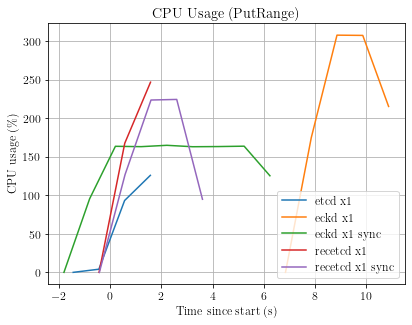

In [7]:
# cpu usage plots

import numpy as np
import matplotlib.pyplot as plt

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.size": 12,
})

f = plt.figure()
f.set_figwidth(6.4 * 1)
f.set_figheight(4.8 * 1)
    
for (k, v) in cpu_usage.items():
    config = json.loads(k)
    bench_type = config["bench_type"]
    if bench_type != "PutRange":
        continue
    
    cluster_size = config["cluster_size"]
    if cluster_size == 1:
        if config["image_name"] == "quay.io/coreos/etcd":
            image = "etcd"
        elif config["image_name"] == "jeffas/eckd":
            image = "eckd"
        elif config["image_name"] == "jeffas/recetcd":
            image = "recetcd"
        else:
            print("unmatched image name:", config["image_name"])

        sync = " sync" if "--sync" in config["extra_args"] else ""

        xs = [x.total_seconds() for x in v[0]]
        ys = v[1]
        
        plt.plot(xs, ys, label=f"{image} x{cluster_size}{sync}")

plt.grid()
plt.title("CPU Usage (PutRange)")
plt.xlabel("Time since start (s)")
plt.ylabel("CPU usage (\%)")
plt.legend()

plt.savefig(f"{exp_dir}/plots/cpu-usage-putrange.pdf")

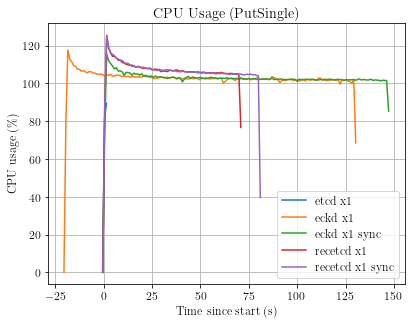

In [8]:
# cpu usage plots

import numpy as np
import matplotlib.pyplot as plt

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.size": 12,
})

f = plt.figure()
f.set_figwidth(6.4 * 1)
f.set_figheight(4.8 * 1)
    
for (k, v) in cpu_usage.items():
    config = json.loads(k)
    bench_type = config["bench_type"]
    if bench_type != "PutSingle":
        continue
    
    cluster_size = config["cluster_size"]
    if cluster_size == 1:
        if config["image_name"] == "quay.io/coreos/etcd":
            image = "etcd"
        elif config["image_name"] == "jeffas/eckd":
            image = "eckd"
        elif config["image_name"] == "jeffas/recetcd":
            image = "recetcd"
        else:
            print("unmatched image name:", config["image_name"])

        sync = " sync" if "--sync" in config["extra_args"] else ""

        xs = [x.total_seconds() for x in v[0]]
        ys = v[1]
        
        plt.plot(xs, ys, label=f"{image} x{cluster_size}{sync}")

plt.grid()
plt.title("CPU Usage (PutSingle)")
plt.xlabel("Time since start (s)")
plt.ylabel("CPU usage (\%)")
plt.legend()

plt.savefig(f"{exp_dir}/plots/cpu-usage-putsingle.pdf")

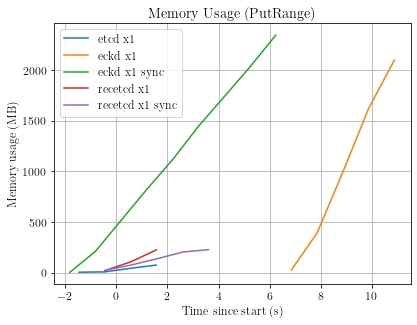

In [9]:
# mem usage plots

import numpy as np
import matplotlib.pyplot as plt

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.size": 12,
})

f = plt.figure()
f.set_figwidth(6.4 * 1)
f.set_figheight(4.8 * 1)
    
for (k, v) in mem_usage.items():
    config = json.loads(k)
    bench_type = config["bench_type"]
    if bench_type != "PutRange":
        continue
    
    cluster_size = config["cluster_size"]
    if cluster_size == 1:
        if config["image_name"] == "quay.io/coreos/etcd":
            image = "etcd"
        elif config["image_name"] == "jeffas/eckd":
            image = "eckd"
        elif config["image_name"] == "jeffas/recetcd":
            image = "recetcd"
        else:
            print("unmatched image name:", config["image_name"])

        sync = " sync" if "--sync" in config["extra_args"] else ""

        xs = [x.total_seconds() for x in v[0]]
        ys = np.array(v[1]) / 1_000_000
        
        plt.plot(xs, ys, label=f"{image} x{cluster_size}{sync}")

plt.grid()
plt.title("Memory Usage (PutRange)")
plt.xlabel("Time since start (s)")
plt.ylabel("Memory usage (MB)")
plt.legend()

plt.savefig(f"{exp_dir}/plots/mem-usage-putrange.pdf")

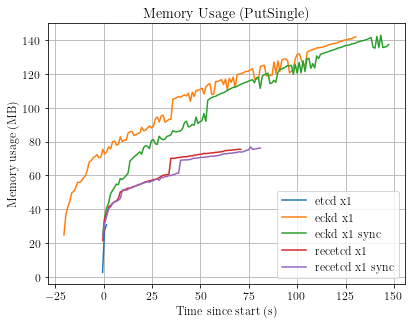

In [10]:
# mem usage plots

import numpy as np
import matplotlib.pyplot as plt

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.size": 12,
})

f = plt.figure()
f.set_figwidth(6.4 * 1)
f.set_figheight(4.8 * 1)
    
for (k, v) in mem_usage.items():
    config = json.loads(k)
    bench_type = config["bench_type"]
    if bench_type != "PutSingle":
        continue
    
    cluster_size = config["cluster_size"]
    if cluster_size == 1:
        if config["image_name"] == "quay.io/coreos/etcd":
            image = "etcd"
        elif config["image_name"] == "jeffas/eckd":
            image = "eckd"
        elif config["image_name"] == "jeffas/recetcd":
            image = "recetcd"
        else:
            print("unmatched image name:", config["image_name"])

        sync = " sync" if "--sync" in config["extra_args"] else ""

        xs = [x.total_seconds() for x in v[0]]
        ys = np.array(v[1]) / 1_000_000
        
        plt.plot(xs, ys, label=f"{image} x{cluster_size}{sync}")

plt.grid()
plt.title("Memory Usage (PutSingle)")
plt.xlabel("Time since start (s)")
plt.ylabel("Memory usage (MB)")
plt.legend()

plt.savefig(f"{exp_dir}/plots/mem-usage-putsingle.pdf")